# <center> IESO ML Project </center>

<center> notebook five <br> Decision Trees <br> and<br> Upsampling </center>

Prepared by Behrouz ShakeriFard <br>

email: bshakeri@torontomu.ca <br>
April 2024

<hr>

In the previous notebook we spent some time working with Logistic Regression, and best result that we managed to achieve was 188 True Positives, out of 238 total positives. We are hoping to do a little better with Decision Trees. But before getting started with Decision Trees, let's spend a few moments and discuss model evaluation.

<br> 

<hr>

## <center> Model Evaluation </center>

#### Precision and Recall

Because of the fact that accuracy alone can be misleading depending on the class balance of the data, alternative metrics consider the relative proportions of correct and incorrect classifications in both the positive and negative classes. Two of the most common are *precision* and *recall*. 

Precision measures what proportion of a model assigned to positive are actually members of the positive class:

$$Precision = \frac{TP}{TP+FP}$$

On the other hand, recall measures how many members of the positive class the model correctly identified out of the total positives:

$$Recall = \frac{TP}{TP+FN}$$

<hr>

In our case, True Positives are absolutely crucial. However, whether Precision would be a better metric, or Recall, requires some discussion.

#### False Positive:
False Positives represent no significant cost to our system. They are errors caused by the model which result in our system disengaging the residential from the grid, and utilizing the energy storage unit. This error represents a small cost, which is associated with recharging the storage unit. Since the storage unit is likely to becharged when prices dip below $4 for each MWh, we can regard the cost of this error negligible.

#### False Negative
False negatives represent a significant cost to our system. When prices go beyond the threshold, and our Machine Learning model fails to predict the occurance of a peak, the client ends up <i> paying</i> peak prices for his/her electricity consumption. Hence, <i> False Negatives</i> represent a significant cost.

Due to the reasoning mentioned above, it would be wiser to optimize <i> Recall</i>.

<hr>

Now that we have discussed elementary topics regarding model evaluation, we can move on to the next steps.

Let's import a few useful packages, and our data, and get started with some fun stuff.

In [1]:
# importing a few useful packages
import numpy as np
import pandas as pd


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import style

In [3]:
# Let's import our data
df = pd.read_csv('df_ieso_cleaned_2021.csv')

new_features_df = pd.read_csv('New Features IESO ML 2024.csv')

In [4]:
# sanity check
df.head()

,Unnamed: 0,Date Time,Market Demand,Ontario Demand,HOEP,Output,capability
0,0,2021-01-01 01:00:00,16057,14112,31.74,14301.0,26203.0
1,1,2021-01-01 02:00:00,15516,13504,17.61,13786.0,26494.0
2,2,2021-01-01 03:00:00,15185,13155,14.36,13507.0,26587.0
3,3,2021-01-01 04:00:00,14940,12892,10.26,13505.0,26749.0
4,4,2021-01-01 05:00:00,14802,12798,6.03,12881.0,26843.0


In [5]:
# Some clean-up is due
df.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
df.index = pd.to_datetime(df['Date Time'])
df.drop('Date Time', inplace=True, axis=1)

In [7]:
# sanity check
new_features_df.head()

,Unnamed: 0,2021 Demand,Annual Surplus,Output/Cap,Market Surplus
0,0,14112,-893,0.545777,189.0
1,1,13504,-609,0.520344,282.0
2,2,13155,-601,0.508030,352.0
3,3,12892,-532,0.504879,613.0
4,4,12798,-445,0.479864,83.0


In [8]:
new_features_df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
# sanity check 
new_features_df.head()

,2021 Demand,Annual Surplus,Output/Cap,Market Surplus
0,14112,-893,0.545777,189.0
1,13504,-609,0.520344,282.0
2,13155,-601,0.508030,352.0
3,12892,-532,0.504879,613.0
4,12798,-445,0.479864,83.0


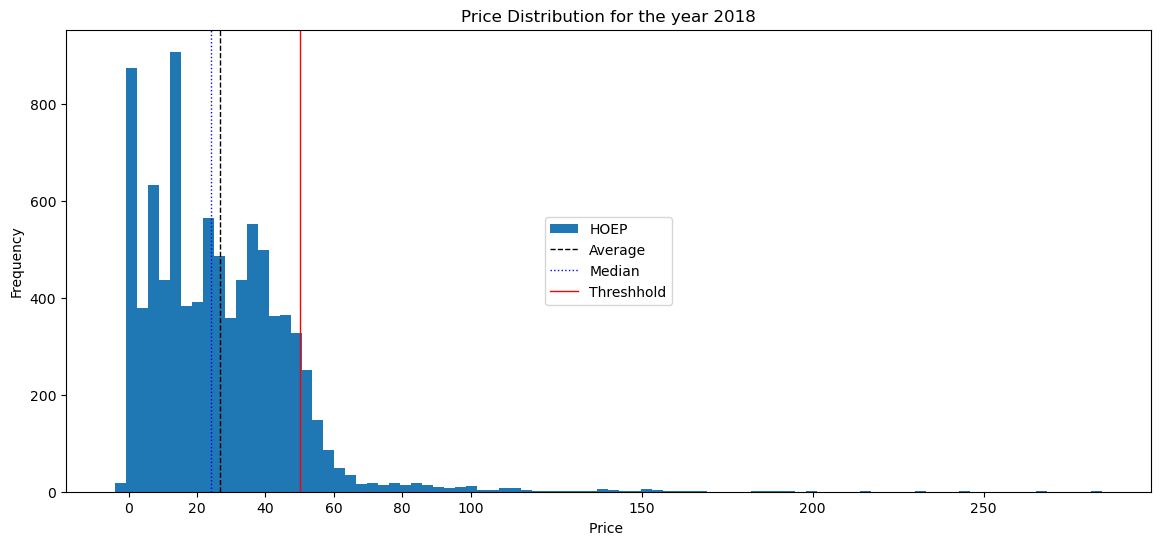

In [10]:
# initiate the plot and setting the size
plt.figure(figsize=(14,6))

# filtering values and selecting the column for our histogram
filtered_price = df[df['HOEP'] <= 300]['HOEP']
filtered_price.plot(kind='hist',bins=90)

# mean or average of the distribution
plt.axvline(df['HOEP'].mean(), color='k', linestyle='dashed', linewidth=1, label='Average')

# median of the distribution
plt.axvline(df['HOEP'].median(), color='b', linestyle=':', linewidth=1, label='Median')

# a hypothetical threshhold
plt.axvline(50, color='r', linestyle='solid', linewidth=1, label='Threshhold')

plt.xlabel('Price ')
plt.ylabel('Frequency')
plt.xticks([0,20,40,60,80,100,150,200,250])

# Title of our graph
plt.title('Price Distribution for the year 2018')
plt.legend(loc='center')
plt.show()

#### setting up our target dataframe

In [11]:
# new dataframe
df_target=pd.DataFrame()

# importing price
df_target['Price'] = df['HOEP']

# connect column represents a True or False (binary) variable
df_target['peak'] = df_target.apply(lambda x: int(0) if int(x['Price']) < 50 else int(1), axis=1)

In [12]:
# total instances of peak price happening
df_target['peak'].sum()

838

In [13]:
# percentage of peak occurances overal
df_target['peak'].sum()/8760 * 100

9.5662100456621

In [14]:
new_features_df.columns

Index(['2021 Demand', 'Annual Surplus', 'Output/Cap', 'Market Surplus'], dtype='object')

In [18]:
features_df = pd.DataFrame()

# selecting the best three features
features_df = new_features_df[['2021 Demand','Market Surplus','Output/Cap']]

In [15]:
from sklearn.model_selection import train_test_split

In [19]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(features_df, df_target['peak'], test_size=0.3, random_state=1)

In [20]:
y_train.sum()

600

In [21]:
y_test.sum()

238

Cool. Now we can get started with our data modelling!

<hr>

# Decision Trees

In [22]:
from sklearn.tree import DecisionTreeClassifier

In [23]:
#Fit to the training data
DT_model = DecisionTreeClassifier()
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  1.0
The TEST classification accuracy is:  0.8987823439878234


Right!

This is interesting, and worthy of a short discussion. When TRAINING score reaches 100% we can be sure that our model is over-fitting and thus, by adjusting a few parameters, we can improve the score on TEST data.

### A Few Words about Accuracy

It would be foolish to feel impressed by good accuracy scores; for the simple reason that detecting True Negatives are VERY VERY easy. So, although accuracy is a good indicator that something is working, we cannot feel pleased with it AT ALL! Remember, we need the highest <i> RECALL</i> score that we can possibly achieve!

In [24]:
#Fit to the training data
DT_model = DecisionTreeClassifier(max_depth=3)
DT_model.fit(X_train, y_train)

print(f"The TRAIN classification accuracy is:  {DT_model.score(X_train,y_train)}")
print(f"The TEST classification accuracy is:  {DT_model.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.9249836921069797
The TEST classification accuracy is:  0.9250380517503806


That's Much Better!!!

In [26]:
# importing useful packages
from sklearn.metrics import confusion_matrix, classification_report

In [28]:
y_pred = DT_model.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[2347,   43],
       [ 154,   84]])

In [38]:
# Get class predictions
y_pred = DT_model.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

/home/behroox/anaconda3/envs/ML_experiment/lib/python3.8/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


,Predicted Non-peak,Predicted Peak
True Non-Peak,2347,43
True Peak Price,154,84


In [27]:
print(classification_report(y_test, DT_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      2390
           1       0.66      0.35      0.46       238

    accuracy                           0.93      2628
   macro avg       0.80      0.67      0.71      2628
weighted avg       0.91      0.93      0.91      2628



Right.

This is not awful, considering that we have JUST started. We need to do UPSAMPLING before we can really judge the performance of the model. So, without further due, let's get started with upsampling!

<hr>

### Upsampling

In [29]:
# upsample the credit card example
from sklearn.utils import resample

In [30]:
df_target.reset_index(inplace=True)

In [31]:
X_train, X_test, y_train, y_test = train_test_split(features_df, df_target['peak'], test_size = 0.3, random_state=1)

# Upsample
print('Number of class 1 examples before resampling:', X_train[y_train == 1].shape[0])

Number of class 1 examples before resampling: 600


In [32]:
X_upsampled, y_upsampled = resample(X_train[y_train == 1], 
                                    y_train[y_train == 1], 
                                    replace=True, 
                                    # this line aims to truly balance the classes, by getting the number of class 0
                                    # and repeating the resampling process until class 1 counts gets on par with class 0
                                    n_samples=X_train[y_train == 0].shape[0], 
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape[0])

# Combine upsample with original data
X_train_bal = np.vstack((X_train[y_train == 0], X_upsampled))
y_train_bal = np.hstack((y_train[y_train == 0], y_upsampled))

Number of class 1 examples after: 5532


In [33]:
X_test = X_test.values

In [34]:
#Fit to the training data

DT_balanced = DecisionTreeClassifier(max_depth=3)
DT_balanced.fit(X_train_bal, y_train_bal)

# evaluate on the original test set - NO UPSAMPLING
y_pred_bal = DT_balanced.predict(X_test) 

In [36]:
print(f"The TRAIN classification accuracy is:  {DT_balanced.score(X_train_bal,y_train_bal)}")
print(f"The TEST classification accuracy is:  {DT_balanced.score(X_test,y_test)}")

The TRAIN classification accuracy is:  0.7956435285610991
The TEST classification accuracy is:  0.878234398782344


In [37]:
# Get class predictions
y_pred = DT_balanced.predict(X_test)

# Generate confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    cf_matrix, 
    columns=["Predicted Non-peak", "Predicted Peak"],
    index=["True Non-Peak", "True Peak Price"]
)

display(cf_df)

,Predicted Non-peak,Predicted Peak
True Non-Peak,2143,247
True Peak Price,73,165


In [39]:
print(classification_report(y_test, DT_balanced.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      2390
           1       0.40      0.69      0.51       238

    accuracy                           0.88      2628
   macro avg       0.68      0.79      0.72      2628
weighted avg       0.92      0.88      0.89      2628



This is improvement.

our previous recall score was:

$$84/84+154$$

In [41]:
84/(84+154)

0.35294117647058826

We have improved to:

$$165/(165+73)$$

In [42]:
165/(165+73)

0.6932773109243697

<hr>
Reminder:

$$Recall = \frac{TP}{TP+FN}$$

<hr>

An improvement from 0.35 to 0.69 is a near doubling!

However, we are not quite done yet. Next, we will try Random Forests.

<hr>

This concludes the Decision Tree notebook. <br>
End of Notebook Five.